In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd
from shapely import geometry
from geopandas import GeoSeries, GeoDataFrame

# Import Data

In [3]:
#read data in from pickle file
df = pd.read_pickle('C:/Users/Stacey/Downloads/NY_complaint_data_cleaned_with_XY.pkl')

In [4]:
df.shape

(5560057, 29)

In [5]:
df.head(1)

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,...,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,CMPLNT_FR_DATE,CMPLNT_FR_DATE_YEAR,CMPLNT_FR_DATE_MONTH,BORO,CAT_OFNS,BORO_PREC
0,101109527,12/31/2015,23:45:00,NaT,nan,2015-12-31,113,FORGERY,729.0,"FORGERY,ETC.,UNCLASSIFIED-FELO",...,1007314.0,241257.0,40.828848,-73.916661,2015-12-31,2015,12,BRONX,FELONY-FORGERY,BRONX-44


# Choose a point and a radius

Based on the data exploration Precinct 75 in Brooklyn has the highest overall crime rates and Grand Larceny is the most common Felony in all boroughs. Start with the centroid of precinct 75 and experiment with different radius values

# Get the precinct shapefile

In [6]:
#open the shape file from 
#https://www1.nyc.gov/site/planning/data-maps/open-data/districts-download-metadata.page
df_prec = gpd.read_file('zip://'+'nypp.zip')

In [7]:
type(df_prec)

geopandas.geodataframe.GeoDataFrame

In [8]:
df_prec.head(1)

,Precinct,Shape_Leng,Shape_Area,geometry
0,1,79979.343304,4.718208e+07,(POLYGON ((972081.7882080078 190733.4674072266...


In [9]:
#check CRS
df_prec.crs

{'datum': 'NAD83',
 'lat_0': 40.16666666666666,
 'lat_1': 40.66666666666666,
 'lat_2': 41.03333333333333,
 'lon_0': -74,
 'no_defs': True,
 'proj': 'lcc',
 'units': 'us-ft',
 'x_0': 300000,
 'y_0': 0}

(array([  900000.,   925000.,   950000.,   975000.,  1000000.,  1025000.,
         1050000.,  1075000.,  1100000.]),
 <a list of 9 Text xticklabel objects>)

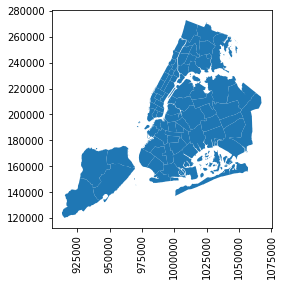

In [10]:
# view map
df_prec.plot()
plt.xticks(rotation=90)

The X,Y coordinates in the crime dataset are also NAD83 so there is no need to project to a different CRS (coordinate reference system) and units are in feet so the distance calculations are easier.

# Remove missing X_coord/Y_coord data points and missing crime types

In [11]:
#remove rows where latitude or longitude is missing
df2 = df[~( (df.X_COORD_CD.isnull()) | (df.Y_COORD_CD.isnull()) )]

In [12]:
#view number of records
df2.shape, df.shape

((5367697, 29), (5560057, 29))

In [13]:
#remove observations with null crime typee
df2 = df2[~df2.OFNS_DESC.isnull()]

In [14]:
#view number of records
df2.shape, df.shape

((5349607, 29), (5560057, 29))

# Find the centroid of the precincts

In [15]:
#set up blank lists for the x and y coordinate of the centroids
cent_x = []
cent_y = []
#get the centroid for each precinct
for index, row in df_prec.iterrows():
    x = row.geometry.centroid.x
    y = row.geometry.centroid.y
    cent_x.append(x)
    cent_y.append(y)

In [16]:
#view the lists
cent_x[0:5],cent_y[0:5]

([980907.7184392913,
  985041.1301694768,
  983590.0887902885,
  988700.437564227,
  988854.6110639743],
 [197854.98359563862,
  200285.7478161191,
  206569.38285115844,
  199930.45271963626,
  203875.07164824434])

In [17]:
#add the x and y coordinates of the centroids to the dataframe
df_prec['centroid_x'] = cent_x
df_prec['centroid_y'] = cent_y

In [18]:
df_prec.head(1)

,Precinct,Shape_Leng,Shape_Area,geometry,centroid_x,centroid_y
0,1,79979.343304,4.718208e+07,(POLYGON ((972081.7882080078 190733.4674072266...,980907.718439,197854.983596


In [19]:
df2.head(1)

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,...,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,CMPLNT_FR_DATE,CMPLNT_FR_DATE_YEAR,CMPLNT_FR_DATE_MONTH,BORO,CAT_OFNS,BORO_PREC
0,101109527,12/31/2015,23:45:00,NaT,nan,2015-12-31,113,FORGERY,729.0,"FORGERY,ETC.,UNCLASSIFIED-FELO",...,1007314.0,241257.0,40.828848,-73.916661,2015-12-31,2015,12,BRONX,FELONY-FORGERY,BRONX-44


In [20]:
#supress scientific notation
pd.set_option('display.float_format', lambda x: '%.2f' % x)

Confirm coordinate systems are the same

In [21]:
#view summary stats on coordinate system of the crime dataframe
df2[['X_COORD_CD','Y_COORD_CD']].describe()

,X_COORD_CD,Y_COORD_CD
count,5349607.00,5349607.00
mean,1004648.93,206904.91
std,21454.91,30486.30
min,913319.00,120829.00
25%,991707.00,184143.00
50%,1004298.00,205561.00
75%,1016282.00,235177.00
max,1067298.00,271820.00


In [22]:
#view summary stats on coordinate system for the precinct dataframe
df_prec[['centroid_x','centroid_y']].describe()

,centroid_x,centroid_y
count,77.00,77.00
mean,1003248.20,204226.40
std,23137.11,30993.17
min,927028.43,134921.13
25%,989215.37,182718.03
50%,1000670.97,203444.65
75%,1015339.92,229141.25
max,1057214.74,264436.88


# Consider a radius around the centroid

Get the centroid for precinct 75

In [23]:
prec_75 = df_prec[df_prec.Precinct == 75]
prec_75

,Precinct,Shape_Leng,Shape_Area,geometry,centroid_x,centroid_y
46,75,114009.99,183100917.81,(POLYGON ((1025825.841796875 166404.5057983398...,1018265.79,181367.64


In [24]:
#set point P
P = geometry.Point(prec_75.centroid_x, prec_75.centroid_y)
print(P)

POINT (1018265.789448284 181367.6417959543)


In [25]:
type(P)

shapely.geometry.point.Point

In [26]:
#set radius in feet (5280 feet per mile)
R = 5280/4 #1/4 mile
R

1320.0

Set up a new dataframe for the crime data

In [27]:
#copy the dataframe
df3 = df2.copy()

In [28]:
'''
# create a circle buffer from one of the points
distance = R1
circle_buffer = P.buffer(distance)
'''

'\n# create a circle buffer from one of the points\ndistance = R1\ncircle_buffer = P.buffer(distance)\n'

In [29]:
#convert the x_coord and y_coord to a geometric object
points = [geometry.Point(xy) for xy in zip(df3.X_COORD_CD, df3.Y_COORD_CD)]

In [30]:
#add points to the dataframe
df3['points'] = points

In [31]:
#compute distance from all observed points to point P
dist = [p.distance(P) for p in points]

In [32]:
#add the distances to the dataframe
df3['distance'] = dist

In [33]:
df3.head(1)

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,...,Latitude,Longitude,CMPLNT_FR_DATE,CMPLNT_FR_DATE_YEAR,CMPLNT_FR_DATE_MONTH,BORO,CAT_OFNS,BORO_PREC,points,distance
0,101109527,12/31/2015,23:45:00,NaT,nan,2015-12-31,113,FORGERY,729.00,"FORGERY,ETC.,UNCLASSIFIED-FELO",...,40.83,-73.92,2015-12-31,2015,12,BRONX,FELONY-FORGERY,BRONX-44,POINT (1007314 241257),60882.48


In [34]:
#Check if each point is within radius R (1 for yes, 0 for no)
df3['R1320'] = np.where(df3.distance <= R, 1, 0)

In [35]:
#check the resulting dataframe
df3[['BORO','PRECINCT','X_COORD_CD','Y_COORD_CD','points','distance','R1320']].sort_values('distance')

,BORO,PRECINCT,X_COORD_CD,Y_COORD_CD,points,distance,R1320
265490,BROOKLYN,75,1018214.00,181284.00,POINT (1018214 181284),98.38,1
492454,BROOKLYN,75,1018214.00,181284.00,POINT (1018214 181284),98.38,1
4871090,BROOKLYN,75,1018214.00,181284.00,POINT (1018214 181284),98.38,1
264233,BROOKLYN,75,1018214.00,181284.00,POINT (1018214 181284),98.38,1
1524858,BROOKLYN,75,1018214.00,181284.00,POINT (1018214 181284),98.38,1
4578196,BROOKLYN,75,1018214.00,181284.00,POINT (1018214 181284),98.38,1
1244772,BROOKLYN,75,1018214.00,181284.00,POINT (1018214 181284),98.38,1
2464482,BROOKLYN,75,1018214.00,181284.00,POINT (1018214 181284),98.38,1
4467420,BROOKLYN,75,1018214.00,181284.00,POINT (1018214 181284),98.38,1
5411652,BROOKLYN,75,1018214.00,181284.00,POINT (1018214 181284),98.38,1


In [36]:
#check the boro and precinct for observations in the radius
df3[['BORO','PRECINCT','X_COORD_CD','Y_COORD_CD','points',
     'distance','R1320']][df3.R1320 == 1].sort_values('distance')
#Boro is always Brooklyn, Precinct is always 75

,BORO,PRECINCT,X_COORD_CD,Y_COORD_CD,points,distance,R1320
492454,BROOKLYN,75,1018214.00,181284.00,POINT (1018214 181284),98.38,1
1249219,BROOKLYN,75,1018214.00,181284.00,POINT (1018214 181284),98.38,1
1520470,BROOKLYN,75,1018214.00,181284.00,POINT (1018214 181284),98.38,1
1520471,BROOKLYN,75,1018214.00,181284.00,POINT (1018214 181284),98.38,1
4871090,BROOKLYN,75,1018214.00,181284.00,POINT (1018214 181284),98.38,1
1520475,BROOKLYN,75,1018214.00,181284.00,POINT (1018214 181284),98.38,1
1524858,BROOKLYN,75,1018214.00,181284.00,POINT (1018214 181284),98.38,1
4467420,BROOKLYN,75,1018214.00,181284.00,POINT (1018214 181284),98.38,1
398759,BROOKLYN,75,1018214.00,181284.00,POINT (1018214 181284),98.38,1
2464482,BROOKLYN,75,1018214.00,181284.00,POINT (1018214 181284),98.38,1


In [37]:
#check precinct 75
df3[df3.PRECINCT == 75][['OFNS_DESC',
 'LAW_CAT_CD', 'PRECINCT', 'X_COORD_CD',
 'Y_COORD_CD', 'Latitude', 'Longitude',
 'CMPLNT_FR_DATE', 'CMPLNT_FR_DATE_YEAR',
 'CMPLNT_FR_DATE_MONTH', 'BORO', 'CAT_OFNS',
 'BORO_PREC', 'points', 'distance',
 'R1320']].sort_values('distance')

,OFNS_DESC,LAW_CAT_CD,PRECINCT,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,CMPLNT_FR_DATE,CMPLNT_FR_DATE_YEAR,CMPLNT_FR_DATE_MONTH,BORO,CAT_OFNS,BORO_PREC,points,distance,R1320
1520469,CRIMINAL MISCHIEF & RELATED OF,MISDEMEANOR,75,1018214.00,181284.00,40.66,-73.88,2012-11-19,2012,11,BROOKLYN,MISDEMEANOR-CRIMINAL MISCHIEF & RELATED OF,BROOKLYN-75,POINT (1018214 181284),98.38,1
1656627,CRIMINAL MISCHIEF & RELATED OF,FELONY,75,1018214.00,181284.00,40.66,-73.88,2012-08-10,2012,8,BROOKLYN,FELONY-CRIMINAL MISCHIEF & RELATED OF,BROOKLYN-75,POINT (1018214 181284),98.38,1
5411652,CRIMINAL MISCHIEF & RELATED OF,MISDEMEANOR,75,1018214.00,181284.00,40.66,-73.88,2016-05-12,2016,5,BROOKLYN,MISDEMEANOR-CRIMINAL MISCHIEF & RELATED OF,BROOKLYN-75,POINT (1018214 181284),98.38,1
4871090,DANGEROUS DRUGS,MISDEMEANOR,75,1018214.00,181284.00,40.66,-73.88,2006-06-07,2006,6,BROOKLYN,MISDEMEANOR-DANGEROUS DRUGS,BROOKLYN-75,POINT (1018214 181284),98.38,1
1244772,BURGLARY,FELONY,75,1018214.00,181284.00,40.66,-73.88,2013-06-18,2013,6,BROOKLYN,FELONY-BURGLARY,BROOKLYN-75,POINT (1018214 181284),98.38,1
1249219,VEHICLE AND TRAFFIC LAWS,MISDEMEANOR,75,1018214.00,181284.00,40.66,-73.88,2013-06-15,2013,6,BROOKLYN,MISDEMEANOR-VEHICLE AND TRAFFIC LAWS,BROOKLYN-75,POINT (1018214 181284),98.38,1
4578196,DANGEROUS DRUGS,MISDEMEANOR,75,1018214.00,181284.00,40.66,-73.88,2006-12-18,2006,12,BROOKLYN,MISDEMEANOR-DANGEROUS DRUGS,BROOKLYN-75,POINT (1018214 181284),98.38,1
2648475,CRIMINAL MISCHIEF & RELATED OF,MISDEMEANOR,75,1018214.00,181284.00,40.66,-73.88,2010-08-24,2010,8,BROOKLYN,MISDEMEANOR-CRIMINAL MISCHIEF & RELATED OF,BROOKLYN-75,POINT (1018214 181284),98.38,1
2692230,ROBBERY,FELONY,75,1018214.00,181284.00,40.66,-73.88,2010-07-25,2010,7,BROOKLYN,FELONY-ROBBERY,BROOKLYN-75,POINT (1018214 181284),98.38,1
5099397,BURGLARY,FELONY,75,1018214.00,181284.00,40.66,-73.88,2006-01-01,2006,1,BROOKLYN,FELONY-BURGLARY,BROOKLYN-75,POINT (1018214 181284),98.38,1


# Group by month by offense type in the radius

In [38]:
#get observations that are in the radius
df_R = df3[df3.R1320 == 1]

In [39]:
df_R.shape

(4665, 32)

In [40]:
#group complaint data by year, month, borough, precinct, category, 
#description
df_agg = df_R[['CMPLNT_NUM','CMPLNT_FR_DATE_YEAR','CMPLNT_FR_DATE_MONTH',
             'BORO','BORO_PREC','PRECINCT','LAW_CAT_CD','OFNS_DESC','CAT_OFNS']
           ].groupby(['CMPLNT_FR_DATE_YEAR','CMPLNT_FR_DATE_MONTH',
                      'BORO','BORO_PREC','PRECINCT','LAW_CAT_CD',
                      'OFNS_DESC','CAT_OFNS'],as_index=False).agg(['count'])

#reformat headers
df_agg.columns = ['_'.join(tup).rstrip('_') for tup in df_agg.columns.values]
df_agg.reset_index(col_level=1,inplace = True)

In [41]:
#identify the offense type
O = 'GRAND LARCENY'

In [42]:
# look at summary of crimes by month for for Grand Larceny 
#for observations in the radius
df_agg_GL = df_agg[df_agg.OFNS_DESC == O]
df_agg_GL.CMPLNT_NUM_count.describe()

count   114.00
mean      2.20
std       1.29
min       1.00
25%       1.00
50%       2.00
75%       3.00
max       6.00
Name: CMPLNT_NUM_count, dtype: float64

There are very few crimes within a quarter mile which will make this more difficult to forecast

# Evaluate additional radiuses

In [43]:
#create a function to evaluate the distance from the radius

def eval_radius(df,R,O):

    #set the column name for the new R column
    col_name = 'R' + str(int(round(R,0)))
    
    #Check if each point is within radius R (1 for yes, 0 for no)
    #Add the column to the dataframe
    df[col_name] = np.where(df.distance <= R, 1, 0)
    
    #get observations that are in the radius
    df_R = df[df[col_name] == 1]
    
    #group complaint data by year, month, borough, precinct, category, 
    #description
    df_agg = df_R[['CMPLNT_NUM','CMPLNT_FR_DATE_YEAR','CMPLNT_FR_DATE_MONTH',
                 'BORO','BORO_PREC','PRECINCT','LAW_CAT_CD','OFNS_DESC','CAT_OFNS']
               ].groupby(['CMPLNT_FR_DATE_YEAR','CMPLNT_FR_DATE_MONTH',
                          'BORO','BORO_PREC','PRECINCT','LAW_CAT_CD',
                          'OFNS_DESC','CAT_OFNS'],as_index=False).agg(['count'])

    #reformat headers
    df_agg.columns = ['_'.join(tup).rstrip('_') for tup in df_agg.columns.values]
    df_agg.reset_index(col_level=1,inplace = True)
    
    df_agg_O = df_agg[df_agg.OFNS_DESC == O]
    print(df_agg_O.CMPLNT_NUM_count.describe())
    
    return df_agg_O

In [44]:
# 1/2 mile radius
df_agg_O_hm = eval_radius(df3,(5280/2),'GRAND LARCENY')

count   132.00
mean      9.24
std       3.83
min       3.00
25%       6.00
50%       9.00
75%      12.00
max      22.00
Name: CMPLNT_NUM_count, dtype: float64


There are a larger number of crimes within a half-mile

In [45]:
df3.head(1)

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,...,CMPLNT_FR_DATE,CMPLNT_FR_DATE_YEAR,CMPLNT_FR_DATE_MONTH,BORO,CAT_OFNS,BORO_PREC,points,distance,R1320,R2640
0,101109527,12/31/2015,23:45:00,NaT,nan,2015-12-31,113,FORGERY,729.00,"FORGERY,ETC.,UNCLASSIFIED-FELO",...,2015-12-31,2015,12,BRONX,FELONY-FORGERY,BRONX-44,POINT (1007314 241257),60882.48,0,0


In [46]:
# One mile radius
df_agg_O_1m = eval_radius(df3,5280,'GRAND LARCENY')

count   133.00
mean     42.79
std      11.97
min       1.00
25%      35.00
50%      41.00
75%      51.00
max      72.00
Name: CMPLNT_NUM_count, dtype: float64


This starts to include other precincts which is why the count is 133 instead of 132 and the min in 1,if we went to a one mile radius the data would have to be grouped without the precinct number

In [47]:
df_agg_O_1m[df_agg_O_1m.CMPLNT_NUM_count ==1]

,CMPLNT_FR_DATE_YEAR,CMPLNT_FR_DATE_MONTH,BORO,BORO_PREC,PRECINCT,LAW_CAT_CD,OFNS_DESC,CAT_OFNS,CMPLNT_NUM_count
3816,2015,5,BROOKLYN,BROOKLYN-69,69,FELONY,GRAND LARCENY,FELONY-GRAND LARCENY,1


In [48]:
df3.head(1)

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,...,CMPLNT_FR_DATE_YEAR,CMPLNT_FR_DATE_MONTH,BORO,CAT_OFNS,BORO_PREC,points,distance,R1320,R2640,R5280
0,101109527,12/31/2015,23:45:00,NaT,nan,2015-12-31,113,FORGERY,729.00,"FORGERY,ETC.,UNCLASSIFIED-FELO",...,2015,12,BRONX,FELONY-FORGERY,BRONX-44,POINT (1007314 241257),60882.48,0,0,0


# P,R,O for modeling
P = centroid of precinct 75 (the highest crime precinct in the city)  
R = 0.5 miles (2640 feet)  
O = Grand Larceny (felony with the highest incidence in all boroughs)  
  
Radius of a 1/4 mile has very few observations, while a radius of a 1/2 mile appears to have enough to create a model while still covering a small area.  
  
Points in lower crime precincts as well as lower incidence crime types will likely require a larger radius to model as there won't be as many crimes within a half mile radius.   

In [49]:
#export modeling dataset
df_agg_O_hm.to_pickle('C:/Users/Stacey/Downloads/NY_complaint_data_for_model.pkl')